# Tukey depth eikonal equation in 2D Cartesian grids

In this notebook, we are interested to solve
$$ |\nabla u(x)| - \int_{(y-x) \cdot \nabla u(x) } \rho(y) dS(y) = 0, \quad  x \in \mathbb{R}^2$$
where $\rho$ is the given data density. The viscosity solution of the PDE $u$ will represent the Tukey depth measure of $\rho$. If $\rho$ is a probability measure, then $x$ such that $u(x) = 0.5$ will be the median of $\rho$.

In [1]:
# Run if you are on Google Colab to install the Python bindings
!bash compile.sh

running build_ext
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c flagcheck.cpp -o flagcheck.o -std=c++17
building 'monotone' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -DVERSION_INFO=0.0.1 -I/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/pybind11/include -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c src/main.cpp -o build/temp.macosx-10.9-x86_64-3.6/src/main.o -std=c++17 -mmacosx-version-min=10.14 -fvisibility=hidden -g0 -stdlib=libc++ -std=c++17
g++ -bundle -undefined dynamic_lookup -L/Users/wonjunlee/miniconda3/envs/cv/lib -arch x86

In [2]:
import os
import numpy as np
import time
import tqdm
import matplotlib.pyplot as plt
from monotone import Tukey2DSolver, interpolate

# make folder if not exists
save_fig_path = 'figures'
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)
save_data_path = 'data'
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

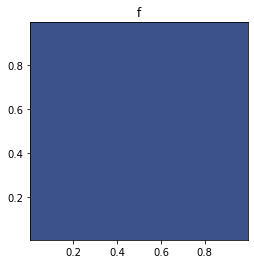

In [55]:
# create an empty f
n = 100
f = np.zeros((n,n))
u = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        u[i,j] = i*n + j

# initializing f
xx = np.linspace(0.5/n,1-0.5/n,n)
X,Y = np.meshgrid(xx,xx)

def f_ellipse():
    f = np.zeros((n,n))
    theta = -np.pi/3.0
    Xr = 0.5 + np.cos(theta)*(X-0.5) - np.sin(theta)*(Y-0.5)
    Yr = 0.5 + np.sin(theta)*(X-0.5) + np.cos(theta)*(Y-0.5)
    f[4*pow(Xr - 0.5,2) + pow(Yr-0.5,2) < 0.5 ** 2] = 1
    return f

# f = f_ellipse()
f[(np.abs(X-0.5)<0.5) & (np.abs(Y-0.5)<0.5)] = 1
# f[(np.abs(X-0.5)<0.3) & (np.abs(Y-0.5)<0.3)] = 1
# f[((X-0.3)**2 + (Y-0.3)**2 <0.22**2) | ((X-0.7)**2 + (Y-0.7)**2 <0.22**2)] = 1
# f[((X-0.25)**2 + (Y-0.25)**2 <0.2**2) | ((X-0.25)**2 + (Y-0.75)**2 <0.2**2) | ((X-0.75)**2 + (Y-0.25)**2 <0.2**2) | ((X-0.75)**2 + (Y-0.75)**2 <0.2**2)] = 1


# returning contiguous arrays in memory
u = np.ascontiguousarray(u, dtype=np.float64)  # solution
f = np.ascontiguousarray(f, dtype=np.float64)  # the right hand side function

# plotting f
fig = plt.figure()
ax = fig.add_subplot()
ax.contourf(X,Y,f)
ax.set_title("f")
ax.set_aspect('equal')
plt.show()

In [58]:
# optimization parameters
max_iter = 500
tolerance= 1e-3

# initialize the HJ solver
stencil_size = 5
solver  = Tukey2DSolver(f, stencil_size)

# Running the iterations
start_time = time.time()
error_array = []
time_array = []

error = 1.0
for i in tqdm.tqdm(range(1,max_iter+1)):
    error = solver.perform_one_iteration(u)
    error_array.append(error)
    time_array.append(time.time() - start_time)
    # print(f"i: {i} error: {error:0.2e} time: {time.time() - start_time:0.2e} sec")
    # if error is less than tolerance stop the iteration
    if error < tolerance or i == max_iter:
        print(f"Tolerance met! i: {i} error: {error:0.2e} time: {time.time() - start_time:0.2e} sec")
        break
    # save figures
    # if i % 10 == 0:
        # fig = plt.figure(figsize=(10,5))
        # ax = fig.add_subplot(121)
        # # ax.contourf(X,Y,u)
        # ax.imshow(u, origin='lower')
        # ax.axis('off')
        # ax.set_aspect('equal')
        # title_str = f"i: {i} error: {error:0.2e} time: {time.time() - start_time:0.2e} sec"
        # plt.title(title_str)
        # ax = fig.add_subplot(122)
        # ax.plot(time_array, error_array,'o-')
        # plt.savefig(f"{save_fig_path}/fig-{i//10}.png")
        # plt.show()
    # save dat
    if i % 100 == 0:
        np.save(f"{save_data_path}/data-{i//100}.npy",u)
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
# ax.contourf(X,Y,u)
ax.imshow(u, origin='lower')
ax.axis('off')
ax.set_aspect('equal')
title_str = f"i: {i} error: {error:0.2e} time: {time.time() - start_time:0.2e} sec\n{np.min(u):0.2e} {np.max(u):0.2e}"
plt.title(title_str)
ax = fig.add_subplot(122)
ax.plot(time_array, error_array,'o-')
plt.savefig(f"{save_fig_path}/fig-{i//10}.png")
plt.show()

Constructor finished. n:  100 stencil size:  5 number of stencils:  40 number of threads:  12


 86%|████████▋ | 432/500 [02:20<00:24,  2.80it/s]

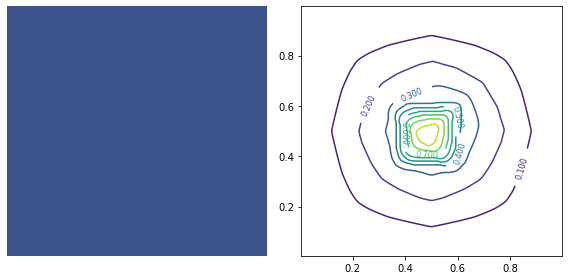

In [ ]:
u1 = np.zeros((n,n))
u1[:] = u[:]
# plotting the result
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(121)
ax.contourf(X,Y,f)
ax.axis('off')
ax = fig.add_subplot(122)
CS = ax.contour(X,Y,u,10)
ax.clabel(CS, inline=1, fontsize=8)
# ax.axis('off')
plt.tight_layout()
plt.savefig(f"{save_fig_path}/tukey-2balls.eps")
plt.show()

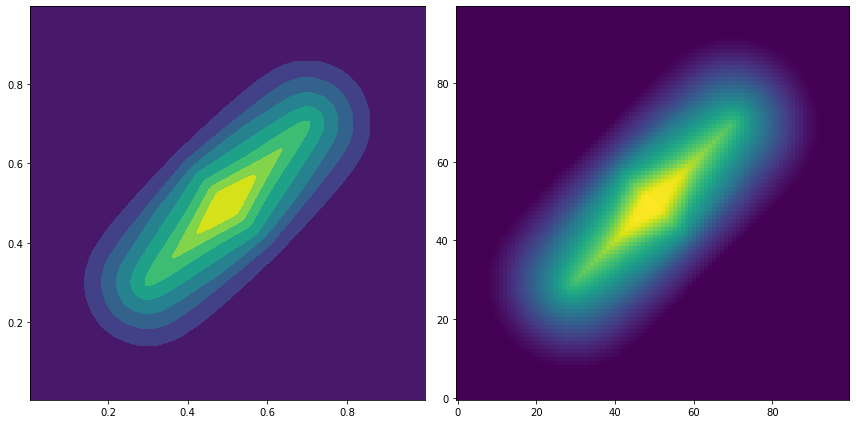

In [16]:
u1 = np.zeros((n,n))
u1[:] = u[:]
# plotting the result
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.contourf(X,Y,u1)
ax = fig.add_subplot(122)
ax.imshow(u, origin='lower')
plt.tight_layout()
plt.savefig(f"{save_fig_path}/2d-plot.png")
plt.show()

 98%|█████████▊| 49/50 [00:02<00:00, 23.37it/s]


Tolerance met! i: 50 error: 1.23e-01 time: 2.10e+00 sec


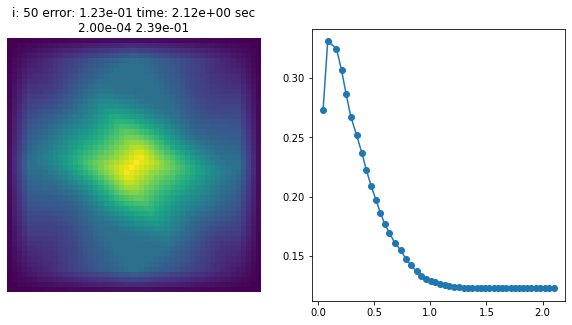

In [6]:
# create an empty f
u = np.zeros((n,n))

usol = 2 * np.minimum(X,1-X) * np.minimum(Y,1-Y)
u[:] = usol[:]

# returning contiguous arrays in memory
u = np.ascontiguousarray(u, dtype=np.float64)  # solution

# Running the iterations
start_time = time.time()
error_array = []
time_array = []

error = 1.0
for i in tqdm.tqdm(range(1,max_iter+1)):
    error = solver.perform_one_iteration_with_bdry(u,0.1)
    error_array.append(error)
    time_array.append(time.time() - start_time)
    # if error is less than tolerance stop the iteration
    if error < tolerance or i == max_iter:
        print(f"Tolerance met! i: {i} error: {error:0.2e} time: {time.time() - start_time:0.2e} sec")
        break
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
# ax.contourf(X,Y,u)
ax.imshow(u, origin='lower')
ax.axis('off')
ax.set_aspect('equal')
title_str = f"i: {i} error: {error:0.2e} time: {time.time() - start_time:0.2e} sec\n{np.min(u):0.2e} {np.max(u):0.2e}"
plt.title(title_str)
ax = fig.add_subplot(122)
ax.plot(time_array, error_array,'o-')
plt.savefig(f"{save_fig_path}/fig-{i//10}.png")
plt.show()

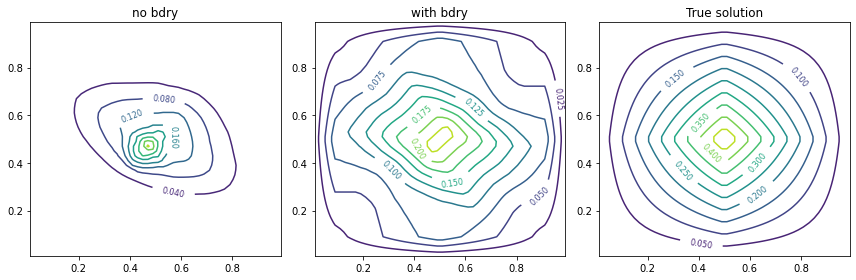

In [7]:
# plotting the result
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
# ax.contourf(X,Y,u1)
CS = ax.contour(X,Y,u1,10)
ax.clabel(CS, inline=1, fontsize=8)
ax.set_title("no bdry")
ax = fig.add_subplot(132)
CS = ax.contour(X,Y,u,10)
ax.clabel(CS, inline=1, fontsize=8)
ax.set_title("with bdry")
ax = fig.add_subplot(133)
CS = ax.contour(X,Y,usol,10)
ax.clabel(CS, inline=1, fontsize=8)
ax.set_title("True solution")
plt.tight_layout()
plt.savefig(f"{save_fig_path}/2d-plot.png")
plt.show()